In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("fraud.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
print(df.isnull().sum())
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n")
print(df.dtypes)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Shape of dataset: (6362620, 11)

Column names:
 Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Data types:

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [7]:
# Count of fraud vs non-fraud
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

# Percentage distribution
fraud_percentage = df['isFraud'].value_counts(normalize=True) * 100
print("\nPercentage distribution:")
print(fraud_percentage)


isFraud
0    6354407
1       8213
Name: count, dtype: int64

Percentage distribution:
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


In [8]:
# Fraud count by transaction type
fraud_by_type = df[df['isFraud'] == 1]['type'].value_counts()
print("Fraud transactions by type:\n")
print(fraud_by_type)

# Total transactions by type
total_by_type = df['type'].value_counts()

# Fraud rate per transaction type
fraud_rate = (fraud_by_type / total_by_type) * 100

print("\nFraud rate (%) by transaction type:\n")
print(fraud_rate)


Fraud transactions by type:

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

Fraud rate (%) by transaction type:

type
CASH_IN          NaN
CASH_OUT    0.183955
DEBIT            NaN
PAYMENT          NaN
TRANSFER    0.768799
Name: count, dtype: float64


In [9]:
# Summary statistics
print("Fraud Amount Stats:\n")
print(df[df['isFraud'] == 1]['amount'].describe())

print("\nNon-Fraud Amount Stats:\n")
print(df[df['isFraud'] == 0]['amount'].describe())


Fraud Amount Stats:

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

Non-Fraud Amount Stats:

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64


C:\Users\SPARKZ EDUCATION\AppData\Local\Temp\ipykernel_20732\2462632011.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


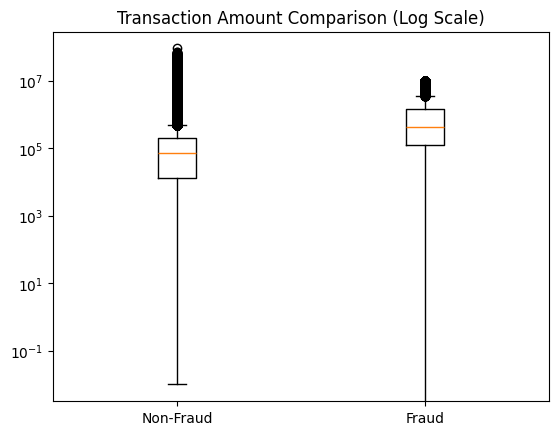

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([
    df[df['isFraud'] == 0]['amount'],
    df[df['isFraud'] == 1]['amount']
], labels=['Non-Fraud', 'Fraud'])
plt.yscale('log')
plt.title("Transaction Amount Comparison (Log Scale)")
plt.show()


In [11]:
# Compare balances for fraud vs non-fraud
balance_cols = [
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest'
]

print("FRAUD TRANSACTIONS BALANCE STATS:\n")
print(df[df['isFraud'] == 1][balance_cols].describe())

print("\nNON-FRAUD TRANSACTIONS BALANCE STATS:\n")
print(df[df['isFraud'] == 0][balance_cols].describe())


FRAUD TRANSACTIONS BALANCE STATS:

       oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
count   8.213000e+03    8.213000e+03    8.213000e+03    8.213000e+03
mean    1.649668e+06    1.923926e+05    5.442496e+05    1.279708e+06
std     3.547719e+06    1.965666e+06    3.336421e+06    3.908817e+06
min     0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
25%     1.258224e+05    0.000000e+00    0.000000e+00    0.000000e+00
50%     4.389835e+05    0.000000e+00    0.000000e+00    4.676420e+03
75%     1.517771e+06    0.000000e+00    1.478287e+05    1.058725e+06
max     5.958504e+07    4.958504e+07    2.362305e+08    2.367265e+08

NON-FRAUD TRANSACTIONS BALANCE STATS:

       oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
count   6.354407e+06    6.354407e+06    6.354407e+06    6.354407e+06
mean    8.328287e+05    8.559702e+05    1.101421e+06    1.224926e+06
std     2.887144e+06    2.924987e+06    3.399202e+06    3.673816e+06
min     0.000000e+00    0.00

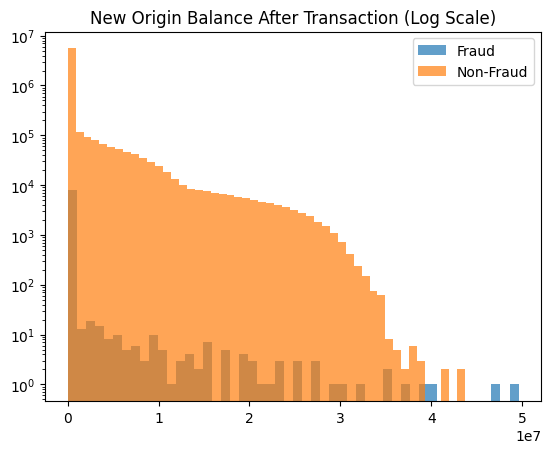

In [12]:
plt.figure()
plt.hist(
    df[df['isFraud'] == 1]['newbalanceOrig'],
    bins=50,
    alpha=0.7,
    label='Fraud'
)
plt.hist(
    df[df['isFraud'] == 0]['newbalanceOrig'],
    bins=50,
    alpha=0.7,
    label='Non-Fraud'
)
plt.yscale('log')
plt.legend()
plt.title("New Origin Balance After Transaction (Log Scale)")
plt.show()


In [13]:
# Balance inconsistency features
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Binary flags
df['isOrigEmpty'] = (df['newbalanceOrig'] == 0).astype(int)
df['isDestEmpty'] = (df['oldbalanceDest'] == 0).astype(int)

# Quick check
df[['errorBalanceOrig', 'errorBalanceDest', 'isOrigEmpty', 'isDestEmpty']].head()


,errorBalanceOrig,errorBalanceDest,isOrigEmpty,isDestEmpty
0,0.0,9839.64,0,1
1,0.0,1864.28,0,1
2,0.0,181.00,1,1
3,0.0,21363.00,1,0
4,0.0,11668.14,0,1


In [14]:
# Drop columns having no predictive value
df_model = df.drop(['nameOrig', 'nameDest'], axis=1)

df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

# Separate features and target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Final shape check
print("Final feature shape:", X.shape)
X.head()



Final feature shape: (6362620, 15)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isOrigEmpty,isDestEmpty,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,1,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0,1,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,0,0.0,181.00,1,1,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,0,0.0,21363.00,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,0,1,False,False,True,False


In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Before SMOTE:")
print(y_train.value_counts())

# SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_res.value_counts())


Before SMOTE:
isFraud
0    4448085
1       5749
Name: count, dtype: int64

After SMOTE:
isFraud
0    4448085
1    4448085
Name: count, dtype: int64


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=30,          # reduced trees
    max_depth=15,             # limit depth
    min_samples_split=50,     # avoid overfitting
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)

print("Optimized Random Forest training completed.")


Optimized Random Forest training completed.


In [21]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_test, y_prob))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      1.00      0.99      2464

    accuracy                           1.00   1908786
   macro avg       0.99      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786


ROC-AUC Score:
0.9995400302538455

Confusion Matrix:
[[1906292      30]
 [      9    2455]]


Top 10 Important Features:

errorBalanceOrig    0.336644
oldbalanceOrg       0.152954
amount              0.093264
newbalanceOrig      0.090977
isOrigEmpty         0.089743
type_TRANSFER       0.066296
type_PAYMENT        0.051931
errorBalanceDest    0.042813
oldbalanceDest      0.018486
type_CASH_OUT       0.016955
dtype: float64


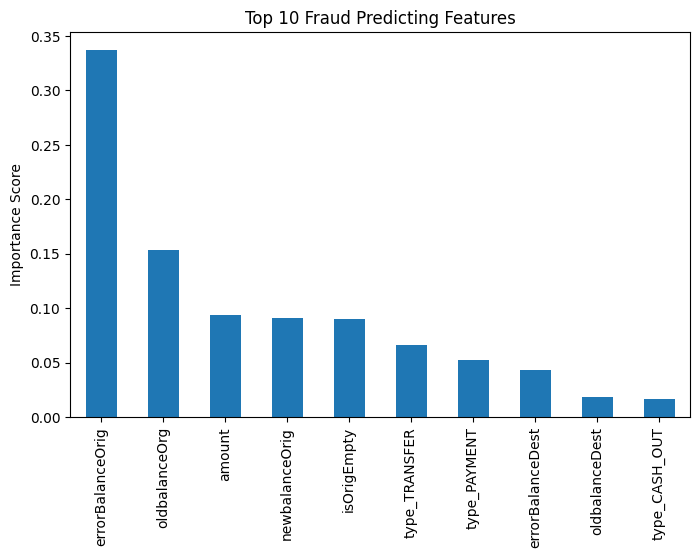

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

# top 10
print("Top 10 Important Features:\n")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(8,5))
feature_importance.head(10).plot(kind='bar')
plt.title("Top 10 Fraud Predicting Features")
plt.ylabel("Importance Score")
plt.show()
